In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TensorFlow v1 compatibility
tf.compat.v1.disable_eager_execution()

# Set TensorFlow to use all available cores
num_cores = 20
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores,allow_soft_placement=True,device_count={'CPU': num_cores})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# List available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


D = 3.8e-11 #m^2/s
C0 = 0.0 #moles/m^3
C1 = 10 #moles/m^3
l = 0.05 #m
t = 100 #s
def pde(x, y):
   
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (dy_t- D*dy_xx)

def f(x):
    return np.sin(np.pi * x / l)
    
def func(x):
    n_terms = 10  # Number of terms in the series to approximate the solution
    result = C0 + (x[:, 0:1] / l) * (C1 - C0)
    for n in range(1, n_terms + 1):
        from scipy.integrate import quad
        integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l), 0, l)
        cn = (2 / l) * integral + (2 / (n * np.pi)) * ((-1)**n * (C1 - C0))  
        term = cn * np.exp(-n**2 * np.pi**2 * D * x[:, 1:2] / l**2) * np.sin(n * np.pi * x[:, 0:1] / l)
        result += term
    return result

geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1] / l) * 10, lambda _, on_boundary: on_boundary)
#ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)
observe_x1 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 10000))).T
observe_y1 = dde.icbc.PointSetBC(observe_x1, func(observe_x1), component=0)
observe_x2 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 500))).T
observe_y2 = dde.icbc.PointSetBC(observe_x2, func(observe_x2), component=0)

data = dde.data.TimePDE(geomtime, pde, [bc,observe_y1,observe_y2], num_domain=5000, solution=func, num_boundary=5000, num_initial=5000, num_test=10000)
layer_size = [2] + [128] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


model = dde.Model(data, net)
model.compile("adam", lr=0.0001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=1000000)

#early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
#losshistory, train_state = model.train(iterations=100, callbacks=[early_stopping])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)



Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5914351967588462271
xla_global_id: -1
]
Compiling model...
Building feed-forward neural network...


c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'build' took 0.357502 s


'compile' took 1.185918 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.84e-02, 5.50e+01, 1.84e+00, 2.11e+00]    [8.23e-04, 5.50e+01, 1.84e+00, 2.11e+00]    [1.06e+00]    
1000      [1.04e-02, 4.11e+00, 1.94e-01, 3.15e-01]    [8.54e-04, 4.11e+00, 1.94e-01, 3.15e-01]    [8.92e-01]    
2000      [1.58e-03, 5.05e-02, 1.71e-01, 2.57e-01]    [1.04e-03, 5.05e-02, 1.71e-01, 2.57e-01]    [1.02e+00]    
3000      [5.67e-04, 1.40e-02, 1.71e-01, 2.47e-01]    [3.79e-04, 1.40e-02, 1.71e-01, 2.47e-01]    [1.02e+00]    
4000      [2.55e-04, 6.30e-03, 1.71e-01, 2.42e-01]    [1.79e-04, 6.30e-03, 1.71e-01, 2.42e-01]    [1.03e+00]    
5000      [2.51e-03, 6.58e-01, 2.20e-01, 4.04e-01]    [5.31e-04, 6.58e-01, 2.20e-01, 4.04e-01]    [8.94e-01]    
6000      [1.57e-04, 4.38e-03, 1.71e-01, 2.37e-01]    [1.24e-04, 4.38e-03, 1.71e-01, 2.37e-01]    [1.03e+00]    
7000      [1.49e-04, 3.

KeyboardInterrupt: 

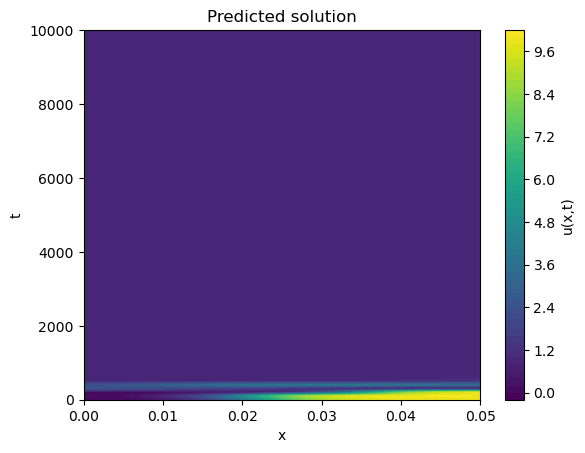

NameError: name 'losshistory' is not defined

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 10000, 100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

# Save the plot and loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [ ]:
# Define points where you want to evaluate the solution
points = np.array([[0.5, 0.5], [0, 0.5]])  # Example points (x, t)

# Use the trained model to predict the solution at these points
y_pred = model.predict(points)
print("Predicted solution at points:", y_pred)


ValueError: Cannot feed value of shape (2, 2) for Tensor Placeholder_98:0, which has shape (None, 1)